In [1]:
!pip install astroquery
!pip install treecorr
!pip install pyhull
!pip install galpy
!pip install gala

     |████████████████████████████████| 6.5MB 11.2MB/s 
     |████████████████████████████████| 51kB 3.9MB/s 
     |████████████████████████████████| 3.2MB 61.9MB/s 
  Created wheel for astroquery: filename=astroquery-0.4.1-cp37-none-any.whl size=3831874 sha256=5707afcd36a43eb0d99e470ae195b5767091c1be114bf02df17d654e0c61cd39
  Stored in directory: /root/.cache/pip/wheels/88/f8/b7/a254cd96e808f708bc0b7d755a8e095c56fbbe94099d7b464f
Successfully built astroquery
     |████████████████████████████████| 1.5MB 12.7MB/s 
     |████████████████████████████████| 51kB 4.2MB/s 
  Created wheel for treecorr: filename=TreeCorr-4.2.0-cp37-cp37m-linux_x86_64.whl size=6155128 sha256=87fdb83bf9044e7db5a8e4a5a2e80862a4cec783a899ac4fbbfe47048f8112f1
  Stored in directory: /root/.cache/pip/wheels/ac/0c/af/29dd12f7ec1dfc5a01025ab1038f6ecd11725d8139c4d75231
  Created wheel for LSSTDESC.Coord: filename=LSSTDESC.Coord-1.2.1-cp37-cp37m-linux_x86_64.whl size=32157 sha256=f53765dbfb754b6456145883dc4618746f2d1dcc

In [2]:
# IMPORT STATEMENTS
import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
from astroquery.gaia import Gaia

#%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
import treecorr

# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [3]:
from astroquery.gaia import Gaia
tables = Gaia.load_tables(only_names=True)
for table in (tables):
    print (table.get_qualified_name())

INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]
external.external.apassdr9
external.external.gaiadr2_geometric_distance
external.external.gaiaedr3_distance
external.external.galex_ais
external.external.ravedr5_com
external.external.ravedr5_dr5
external.external.ravedr5_gra
external.external.ravedr5_on
external.external.sdssdr13_photoprimary
external.external.skymapperdr1_master
external.external.skymapperdr2_master
external.external.tmass_xsc
public.public.hipparcos
public.public.hipparcos_newreduction
public.public.hubble_sc
public.public.igsl_source
public.public.igsl_source_catalog_ids
public.public.tycho2
public.public.dual
tap_config.tap_config.coord_sys
tap_config.tap_config.properties
tap_schema.tap_schema.columns
tap_schema.tap_schema.key_columns
tap_schema.tap_schema.keys
tap_schema.tap_schema.schemas
tap_schema.tap_schema.tables
gaiaedr3.gaiaedr3.gaia_source
gaiaedr3.gaiaedr3.ag

# Extract Gaia Data and Show spatial slices

In [4]:
job = Gaia.launch_job_async("SELECT gaiaedr3.gaia_source.phot_g_mean_mag, gaia_source.ra,gaia_source.dec, gaia_source.parallax, gaia_source.pm,gaia_source.phot_g_mean_mag, gaia_source.dr2_radial_velocity, gaia_source.pmra, gaia_source.pmdec, gaia_source.bp_rp \
FROM gaiaedr3.gaia_source \
WHERE gaiaedr3.gaia_source.parallax>10 \
AND gaiaedr3.gaia_source.parallax/gaiaedr3.gaia_source.parallax_error >10 \
AND gaiaedr3.gaia_source.dr2_radial_velocity IS NOT NULL"\
, dump_to_file=True)

#AND gaiaedr3.gaia_source.phot_g_mean_mag + 5 - 5*log10(1000/gaiaedr3.gaia_source.parallax) > 5\

print (job)

Jobid: 1619927370180O
Phase: COMPLETED
Owner: None
Output file: async_20210502034930.vot
Results: None


In [5]:
r = job.get_results()
print(len(r))

72633


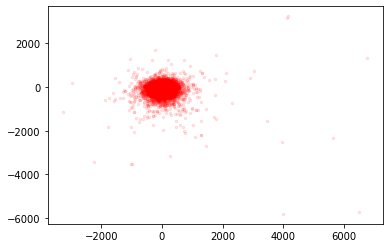

In [6]:

plt.scatter(r['pmra'], r['pmdec'], color='r', alpha=0.1,s = 6)
#plt.xlim(-60,80)
#plt.ylim(-120,30)

plt.show()

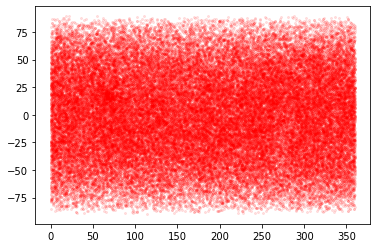

In [7]:
plt.scatter(r['ra'], r['dec'], color='r', alpha=0.1, s = 4)

plt.show()

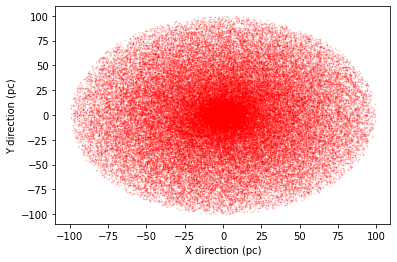

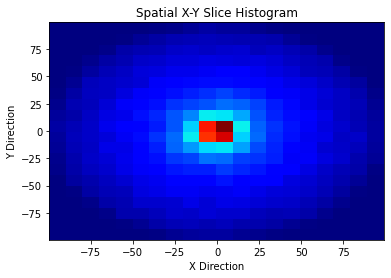

In [8]:
#plt.rcParams.update({
#    "text.usetex": True,
#    "font.family": "sans-serif",
#    "font.sans-serif": ["Helvetica"]})
racos = np.cos(r['ra'])
rasin = np.sin(r['ra'])
deccos = np.cos(r['dec'])
decsin = np.sin(r['dec'])
dist = 1000*np.reciprocal(r['parallax'])
xcoord = np.multiply(dist,np.multiply(racos,deccos))
ycoord = np.multiply(dist,np.multiply(deccos,rasin))
fig = plt.figure()
plt.scatter(xcoord, ycoord, color='r', alpha=0.2, s=0.5)
#plt.title(r"Spatial x-y slice of Gaia Data")
plt.xlabel(r"X direction (pc)")
plt.ylabel(r"Y direction (pc)")
#fig.set_rasterized(True)
plt.savefig("spatial_xy.pdf")
plt.show()

fig2 = plt.figure()
plt.hist2d(xcoord, ycoord, bins = 20, cmap=plt.cm.jet)
plt.title(r"Spatial X-Y Slice Histogram")
plt.xlabel(r"X Direction")
plt.ylabel(r"Y Direction")
fig2.set_rasterized(True)
plt.savefig("spatial_xy_hist.eps")

plt.show()

In [9]:
from astropy import units as u
import astropy.coordinates as astcoord
dec = np.array(r['dec'])
ra = np.array(r['ra'])
pmra = np.array(r['pmra'])
pmdec = np.array(r['pmdec'])
hrv = np.array(r['dr2_radial_velocity'])
dist = np.array(dist)
bp_rp = np.array(r['bp_rp'])
# an astropy skycoordinate object
c1 = astcoord.ICRS(ra=ra*u.degree, dec=dec*u.degree, distance=dist*u.pc, pm_ra_cosdec=pmra*u.mas/u.yr, pm_dec=pmdec*u.mas/u.yr, radial_velocity=hrv*u.km/u.s)
gc1 = c1.transform_to(astcoord.Galactocentric)
(x,y,z) = (gc1.x.value,gc1.y.value,gc1.z.value)
(vx,vy,vz) = (gc1.v_x.value,gc1.v_y.value,gc1.v_z.value)
print(np.count_nonzero(x<-8222))
print(np.count_nonzero(x>-8022))
print(np.count_nonzero(y>100))
print(np.count_nonzero(y<-100))
print(np.count_nonzero(z<-80))
print(np.count_nonzero(z>121))
print(max(z))


0
0
0
0
0
0
120.37229723581746


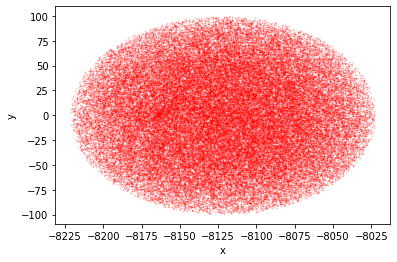

[-8085.12640779 -8043.27473109 -8047.98559921 ... -8084.03786351
 -8101.60730043 -8093.49268824]
[  2.65574887  57.61915258  57.87154271 ...  60.3537918  -32.30048266
 -41.07450607]
[-0.0003284733767886914, -0.007163520942957106, -0.007190686980900492, -0.006080163476605714, -0.0066732501342904645, -0.005359449862890224, -0.004651674152820342, -0.007038192196369433, -0.0043385112806451015, -0.00053959240612546, -0.0006908585632748963, 0.006429414135567439, -0.008678409982999881, 0.005495390012155674, 0.007669313959737137, -0.006127296759618453, 0.009110761037866302, -0.0077100654532334745, 0.006202624848374977, -0.006916661755557528, 0.008143445618528635, -0.0035513494247553447, -0.0072207305911553095, 0.00750340802271596, 0.006637747873561808, 0.007015424877331313, 0.0030239976914286245, 0.0019356759455788138, 0.0019363404651483332, 0.005061879012406434, 0.0051007753169886845, 0.0046605859234950635, 0.0054153254781019325, 0.0015073913119201697, 0.005832406022307883, 0.0044595980487282

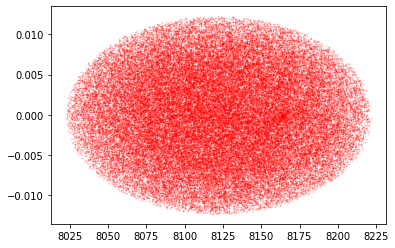

In [10]:
plt.scatter(x,y, color = 'r', alpha = 0.2, s=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#theta = np.arctan2(y,x)
theta = []
for i in range(len(y)):
  theta.append(math.atan(y[i]/x[i]))
print(x)
print(y)
print(theta)
R = np.sqrt(x*x + y*y)
plt.scatter(R,theta, color = 'r', alpha = 0.2, s = 0.5)
plt.show()

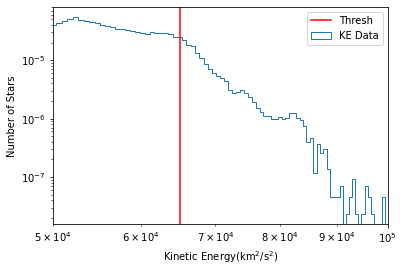

In [11]:
hist_x = (vx*vx)+(vy*vy)+(vz*vz)
n_bins = 200
#fig, axs = plt.subplots(1, 1, figsize =(6, 4), tight_layout = True) 
fig = plt.figure()
#hist_x_final = hist_x/(np.linalg.norm(hist_x))
plt.hist(hist_x, bins = "auto", histtype="step", density=True, label = 'KE Data')
plt.xlim(50000, 100000)
#plt.xlim(0, 90000)
plt.xscale('log')
plt.yscale('log')
plt.axvline(x = 6.5e4, c = 'r', label = 'Thresh')
plt.xlabel(r"Kinetic Energy(km$^2$/s$^2$)")
plt.ylabel(r"Number of Stars")
#plt.title("KE Histogram")
#fig.set_rasterized(True)
plt.legend()
plt.savefig("KE_hist.pdf")
plt.show()


# CMD Diagram

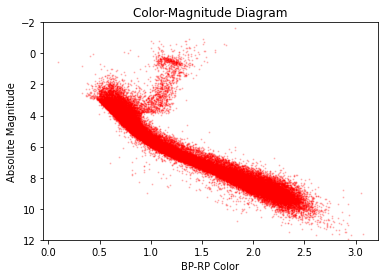

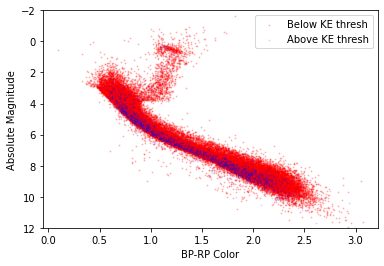

In [12]:
app_mag = np.array(r['phot_g_mean_mag'])
parallax = np.array(r['parallax'])
abs_mag = app_mag + 5 - 5*np.log10(1000/parallax) 
xcoord = bp_rp
ycoord = abs_mag

plt.scatter(xcoord, ycoord, color='r', alpha=0.2, s = 1)
plt.xlabel("BP-RP Color")
plt.ylabel("Absolute Magnitude")
plt.ylim(12,-2)
plt.title("Color-Magnitude Diagram")
plt.show()

xcoord = []
ycoord = []
xcoord_KE = []
ycoord_KE = []

for i in range(len(abs_mag)):
  if hist_x[i]>7e4:
    xcoord_KE.append(bp_rp[i])
    ycoord_KE.append(abs_mag[i])
  else:
    xcoord.append(bp_rp[i])
    ycoord.append(abs_mag[i])

fig = plt.figure()
plt.scatter(xcoord,ycoord,color = 'r', alpha = 0.2, s = 1)
plt.scatter(xcoord_KE, ycoord_KE, color='b', alpha=0.1, s = 1)
plt.xlabel("BP-RP Color")
plt.ylabel("Absolute Magnitude")
plt.ylim(12,-2)
#plt.title(r"Color-Magnitude Diagram")
plt.legend(["Below KE thresh","Above KE thresh"])
plt.savefig("HR_diagram.pdf")
plt.show()
#plt.save(cmd_diagram.eps)

# Bkg Generation and 2 PCF

In [13]:
# background data assuming uniform distribution
from numpy import random
s = len(r)
x_pcf_highKE = []
y_pcf_highKE = []
z_pcf_highKE = []
vx_highKE = []
vy_highKE = []
vz_highKE = []
x_bkg = []
y_bkg = []
z_bkg = []

for i in range(s):
  if hist_x[i]>7e4:
    x_pcf_highKE.append(x[i])
    y_pcf_highKE.append(y[i])
    z_pcf_highKE.append(z[i])
    vx_highKE.append(vx[i])
    vy_highKE.append(vy[i])
    vz_highKE.append(vz[i])

s_highKE = len(x_pcf_highKE)

while len(x_bkg)<3*s:
  x_samp = 200*random.rand() - 100
  y_samp = 200*random.rand() - 100
  z_samp = 200*random.rand() - 100
  if math.sqrt(x_samp*x_samp + y_samp*y_samp + z_samp*z_samp) < 100:
    x_bkg.append(x_samp-8122)
    y_bkg.append(y_samp)
    z_bkg.append(z_samp+20)

N = len(x_bkg)
N = N**(1/3)
x_bkg = np.array(x_bkg)
y_bkg = np.array(y_bkg)
z_bkg = np.array(z_bkg)
ID = x_bkg*x_bkg + N*y_bkg*y_bkg + N*N*z_bkg*z_bkg
#x_bkg = [x for _,x in sorted(zip(ID,x_bkg))]
#y_bkg = [x for _,x in sorted(zip(ID,y_bkg))]
#z_bkg = [x for _,x in sorted(zip(ID,z_bkg))]
a = np.asarray([x_bkg, y_bkg, z_bkg])
np.savetxt("test.bin", a, delimiter=",")
print(N)
print(N**(1/3))
print(60.1753**3)


cat_data_all = treecorr.Catalog(x = x, y = y, z = z)
cat_bkg_all = treecorr.Catalog(x = x_bkg, y = y_bkg, z = z_bkg)

cat_data_highKE = treecorr.Catalog(x=x_pcf_highKE, y=y_pcf_highKE, z=z_pcf_highKE)
cat_bkg_highKE = treecorr.Catalog(x = x_bkg[1:2*s_highKE], y = y_bkg[1:2*s_highKE], z = z_bkg[1:2*s_highKE])

60.17532054613143
3.918677026182507
217898.77680318477


In [14]:
dd_highKE = treecorr.NNCorrelation(min_sep=1., max_sep=200., nbins= 25) # math.sqrt(s))
rr_highKE = treecorr.NNCorrelation(min_sep=1., max_sep=200., nbins= 25) #math.sqrt(s))
dr_highKE = treecorr.NNCorrelation(min_sep=1., max_sep=200., nbins= 25) #math.sqrt(s))
dd_highKE.process(cat_data_highKE)
rr_highKE.process(cat_bkg_highKE)
dr_highKE.process(cat_data_highKE, cat_bkg_highKE)
xi_highKE, varxi_highKE = dd_highKE.calculateXi(rr_highKE,dr_highKE)

In [15]:
dd_all = treecorr.NNCorrelation(min_sep=1., max_sep=200., nbins= 25) # math.sqrt(s))
rr_all = treecorr.NNCorrelation(min_sep=1., max_sep=200., nbins= 25) #math.sqrt(s))
dr_all = treecorr.NNCorrelation(min_sep=1., max_sep=200., nbins= 25) #math.sqrt(s))
dd_all.process(cat_data_all)
rr_all.process(cat_bkg_all)
dr_all.process(cat_data_all, cat_bkg_all)
xi_all, varxi_all = dd_all.calculateXi(rr_all,dr_all)

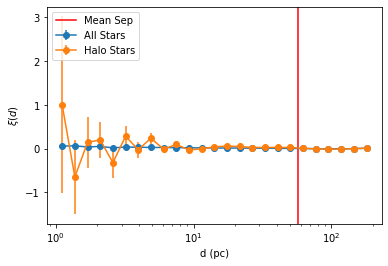

In [16]:
fig = plt.figure()
plt.errorbar(dd_all.rnom, xi_all, yerr = np.sqrt(varxi_all), fmt='-o', label = 'All Stars')
plt.errorbar(dd_highKE.rnom, xi_highKE, yerr = np.sqrt(varxi_highKE), fmt='-o', label = 'Halo Stars')
#plt.title(r'2PCF using the LS Estimator on log scale')
plt.ylabel(r'$\xi(d)$')
plt.xlabel(r'd (pc)')
plt.xscale('log')
#plt.yscale('log')
#plt.xlim(10,200)
plt.axvline(x = 3.86, c='r', label = 'Mean Sep')
plt.legend()
#plt.xlim(0,20)
#plt.ylim(-.5,.5)
#fig.set_rasterized(True)
plt.savefig("2PCF_log.pdf")
plt.show()

# Inverse Sample Transform

72633
72633


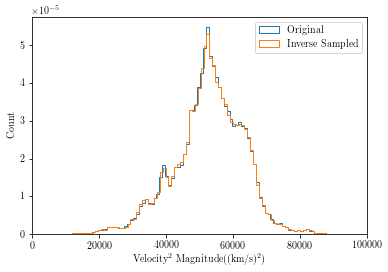

72633
217899


In [173]:
from scipy import integrate
hist_E = vx*vx + vy*vy + vz*vz
hist_E = np.sqrt(hist_E)
Nbs = 100
# set the bin edges for the histogram
#bin_edges = np.linspace(min(hist_E),max(hist_E),Nbs)
# get a histogram of this array, make sure to normalize!
#(hist_E,bin_edges) = np.histogram(hist_E,bins=bin_edges,density=True)
#hist_E = np.array([0] + list(hist_E))

energies_sorted = np.sort(hist_E)
Ndata = len(energies_sorted)

# now that you have a histogram, you can take the cumulative sum
#cum_histE = integrate.cumtrapz(hist_E,)
cum_histE = np.arange(Ndata)/(1.*Ndata)
cum_histE_norm = cum_histE[-1]
cum_histE /= cum_histE_norm

sample_size = int(3*72633)
rndm_no = np.random.random(sample_size)
print(len(cum_histE))
print(len(energies_sorted))
r_energies = np.interp(rndm_no, cum_histE, energies_sorted)

hist_x = (vx*vx)+(vy*vy)+(vz*vz)
fig = plt.figure()
plt.hist(hist_x, bins = 200, histtype="step", density=True, label = 'Original')
#plt.xlim(50000, 100000)
plt.xlim(0, 100000)
plt.xlabel(r'Velocity$^2$ Magnitude((km/s)$^2$)')
plt.ylabel('Count')
#plt.xscale('log')
#plt.yscale('log')
#plt.title("KE Histogram")

plt.hist(np.square(r_energies), bins=200, histtype = 'step', density=True, label = 'Inverse Sampled')
#fig.set_rasterized(True)
plt.legend()
plt.savefig('inverse_sample.pdf')

plt.show()

print(len(hist_x))
print(len(r_energies))

22.066893724170086
[-0.00032847 -0.00716352 -0.00719069 ... -0.00746566  0.0039869
  0.00507496]


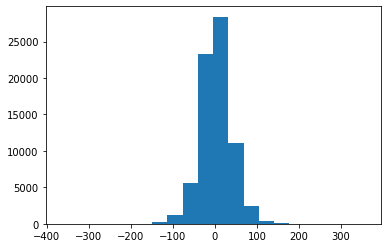

In [18]:
size = len(r_energies)
print(min(r_energies))
from pyhull.voronoi import VoronoiTess
#theta_energies = 2*math.pi*np.random.random(sample_size)
#phi_energies = np.arccos(1-2*(np.random.random(sample_size)))
#v_x = r_energies*np.sin(phi_energies)*np.cos(theta_energies)
#v_y = r_energies*np.sin(phi_energies)*np.sin(theta_energies)
#v_z = r_energies*np.cos(phi_energies)

r_energies_bkg = r_energies
theta_energies_bkg = 2*math.pi*np.random.random(sample_size)
phi_energies_bkg = np.arccos(1-2*(np.random.random(sample_size)))
v_x_bkg = r_energies*np.sin(phi_energies_bkg)*np.cos(theta_energies_bkg)
v_y_bkg = r_energies*np.sin(phi_energies_bkg)*np.sin(theta_energies_bkg)
v_z_bkg = r_energies*np.cos(phi_energies_bkg)


x_bkg = np.array(x_bkg)
y_bkg = np.array(y_bkg)
z_bkg = np.array(z_bkg)

x_highKE = np.array(x_pcf_highKE)
y_highKE = np.array(y_pcf_highKE)
z_highKE = np.array(z_pcf_highKE)

vx_highKE = np.array(vx_highKE)
vy_highKE = np.array(vy_highKE)
vz_highKE = np.array(vz_highKE)

theta = np.arctan(y/x)
v_r = vx*np.cos(theta) + vy*np.sin(theta)
v_T = -vx*np.sin(theta) + vy*np.cos(theta)
v_z = vz
R = np.sqrt(x*x + y*y)
phi = np.arctan(R/z)

theta_bkg = np.arctan(y_bkg/x_bkg)
v_r_bkg = v_x_bkg*np.cos(theta_bkg) + v_y_bkg*np.sin(theta_bkg)
v_T_bkg = -v_x_bkg*np.sin(theta_bkg) + v_y_bkg*np.cos(theta_bkg)
R_bkg = np.sqrt(x_bkg*x_bkg + y_bkg*y_bkg)
phi_bkg = np.arctan(R_bkg/z_bkg)

theta_highKE = np.arctan(y_highKE/x_highKE)
v_r_highKE = vx_highKE*np.cos(theta_highKE) + vy_highKE*np.sin(theta_highKE)
v_T_highKE = -vx_highKE*np.sin(theta_highKE) + vy_highKE*np.cos(theta_highKE)
v_z_highKE = vz_highKE
R_highKE = np.sqrt(x_highKE*x_highKE + y_highKE*y_highKE)
phi_highKE = np.arctan(R_highKE/z_highKE)

##############################################
#TESTING
##############################################
#r_test = np.ones(sample_size)
#print(max(theta))
#fig = plt.figure()
#ax = Axes3D(fig)

# Express the mesh in the cartesian system.
#X = r_test*np.sin(phi)*np.cos(theta)
#Y = r_test*np.sin(phi)*np.sin(theta)
#Z = r_test*np.cos(phi)

# Plot the surface.
#ax.scatter(X, Y, Z)
#plt.show()
################################################
print(theta)
#plt.scatter(R,theta, color = 'r', alpha = 0.5)
#plt.show()
plt.hist(v_r, bins=20)
plt.show()

# Action Angles Calculation

In [19]:
from galpy.actionAngle import estimateDeltaStaeckel
from galpy.potential import MWPotential2014,NFWPotential, HernquistPotential

In [ ]:
len(R)

72633

In [ ]:
from galpy import orbit
s = len(R)
orbits = []
for i in range(s):
  #if i == 1000 or i ==5000 or i == 100 or i == 10000:
   # print(i)
  o = orbit.Orbit([R[i]*u.pc, v_r[i]*u.km/u.s, v_T[i]*u.km/u.s, z[i]*u.pc, v_z[i]*u.km/u.s, theta[i]*u.rad])
  ts= np.linspace(0.,100.,1001)
  o.integrate(ts,MWPotential2014)
  orbits.append(o)

#print(estimateDeltaStaeckel(MWPotential2014,o.R(ts),o.z(ts)))

In [ ]:
!apt-get install gsl-bin libgsl0-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libgsl-dev' instead of 'libgsl0-dev'
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libgsl23 libgslcblas0
Suggested packages:
  gsl-ref-psdoc | gsl-doc-pdf | gsl-doc-info | gsl-ref-html
The following NEW packages will be installed:
  gsl-bin libgsl-dev libgsl23 libgslcblas0
0 upgraded, 4 newly installed, 0 to remove and 34 not upgraded.
Need to get 1,937 kB of archives.
After this operation, 9,537 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgslcblas0 amd64 2.4+dfsg-6 [79.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgsl23 amd64 2.4+dfsg-6 [823 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 gsl-bin amd64 2.4+dfsg-6 [11.3 kB]
Get:4 ht

In [ ]:
%%bash
MINICONDA_INSTALLER_SCRIPT=Miniconda3-4.5.4-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

PREFIX=/usr/local
installing: python-3.6.5-hc3d631a_2 ...
installing: ca-certificates-2018.03.07-0 ...
installing: conda-env-2.6.0-h36134e3_1 ...
installing: libgcc-ng-7.2.0-hdf63c60_3 ...
installing: libstdcxx-ng-7.2.0-hdf63c60_3 ...
installing: libffi-3.2.1-hd88cf55_4 ...
installing: ncurses-6.1-hf484d3e_0 ...
installing: openssl-1.0.2o-h20670df_0 ...
installing: tk-8.6.7-hc745277_3 ...
installing: xz-5.2.4-h14c3975_4 ...
installing: yaml-0.1.7-had09818_2 ...
installing: zlib-1.2.11-ha838bed_2 ...
installing: libedit-3.1.20170329-h6b74fdf_2 ...
installing: readline-7.0-ha6073c6_4 ...
installing: sqlite-3.23.1-he433501_0 ...
installing: asn1crypto-0.24.0-py36_0 ...
installing: certifi-2018.4.16-py36_0 ...
installing: chardet-3.0.4-py36h0f667ec_1 ...
installing: idna-2.6-py36h82fb2a8_1 ...
installing: pycosat-0.6.3-py36h0a5515d_0 ...
installing: pycparser-2.18-py36hf9f622e_1 ...
installing: pysocks-1.6.8-py36_0 ...
installing: ruamel_yaml-0.15.37-py36h14c3975_2 ...
installing: six-1.11

--2021-04-22 18:17:09--  https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh [following]
--2021-04-22 18:17:09--  https://repo.anaconda.com/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58468498 (56M) [application/x-sh]
Saving to: ‘Miniconda3-4.5.4-Linux-x86_64.sh’

     0K .......... .......... .......... .......... ..........  0% 4.31M 13s
    50K .......... .......... .......... .......... ..........  0

In [ ]:
!conda install -c conda-forge gsl

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - 

In [ ]:
!gsl-config --version

/bin/bash: gsl-config: command not found


In [ ]:
!pip install gsl

In [ ]:
!pip uninstall gala

Uninstalling gala-1.3:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/gala-1.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/gala/*
Proceed (y/n)? y
  Successfully uninstalled gala-1.3


In [ ]:
!pip install --upgrade --force-reinstall gala
!pip install -I gala
!pip install --ignore-installed gala
!pip install gala

Processing /root/.cache/pip/wheels/8a/dc/55/7060e35e1fed8acc45d011feea0f5a3df0caaacd615119bb44/gala-1.3-cp37-cp37m-linux_x86_64.whl
     |████████████████████████████████| 15.3MB 1.2MB/s 
     |████████████████████████████████| 645kB 47.4MB/s 
     |████████████████████████████████| 27.4MB 1.5MB/s 
     |████████████████████████████████| 2.0MB 41.1MB/s 
     |████████████████████████████████| 9.7MB 29.0MB/s 
     |████████████████████████████████| 706kB 49.0MB/s 
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.20.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
     

Processing /root/.cache/pip/wheels/8a/dc/55/7060e35e1fed8acc45d011feea0f5a3df0caaacd615119bb44/gala-1.3-cp37-cp37m-linux_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/73/ef/8967d406f3f85018ceb5efab50431e901683188f1741ceb053efcab26c87/numpy-1.20.2-cp37-cp37m-manylinux2010_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/7d/e8/43ffca541d2f208d516296950b25fe1084b35c2881f4d444c1346ca75815/scipy-1.6.3-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/27/0c/c946f63b0a6cf4c385a96de9bffc92abc0ec4e131405d2daa7f11668086b/astropy-4.2.1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/7a/a5/393c087efdc78091afa2af9f1378762f9821c9c1d7a22c5753fb5ac5f97a/PyYAML-5.4.1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/0c/15/cca3ac44776df9ee27286941315dd8b14a598e8d80970200d05f720b9274/Cython-0.29.23-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://

Processing /root/.cache/pip/wheels/8a/dc/55/7060e35e1fed8acc45d011feea0f5a3df0caaacd615119bb44/gala-1.3-cp37-cp37m-linux_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/27/0c/c946f63b0a6cf4c385a96de9bffc92abc0ec4e131405d2daa7f11668086b/astropy-4.2.1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/73/ef/8967d406f3f85018ceb5efab50431e901683188f1741ceb053efcab26c87/numpy-1.20.2-cp37-cp37m-manylinux2010_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/7a/a5/393c087efdc78091afa2af9f1378762f9821c9c1d7a22c5753fb5ac5f97a/PyYAML-5.4.1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/7d/e8/43ffca541d2f208d516296950b25fe1084b35c2881f4d444c1346ca75815/scipy-1.6.3-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/0c/15/cca3ac44776df9ee27286941315dd8b14a598e8d80970200d05f720b9274/Cython-0.29.23-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://

In [ ]:
!pip install gala

Processing /root/.cache/pip/wheels/8a/dc/55/7060e35e1fed8acc45d011feea0f5a3df0caaacd615119bb44/gala-1.3-cp37-cp37m-linux_x86_64.whl


In [ ]:
import gala
from galpy import orbit
import gala.integrate as gi
potential = gala.potential.BovyMWPotential2014()
#integrator = gi.LeapfrogIntegrator(F)

s = len(R)
orbits = []
deltas= []
for i in range(s):
  #if i == 1000 or i ==5000 or i == 100 or i == 10000:
   # print(i)
  w0 = gala.dynamics.PhaseSpacePosition(pos = [x[i], y[i], z[i]]*u.pc, vel = [vx[i], vy[i], vz[i]]*u.km/u.s)
  #orbit = integrator.run(w0, dt=0.5, n_steps=100)
  orbit = potential.integrate_orbit(w0, dt=0.1*u.s, n_steps=10000)
  #ts= np.linspace(0.,100.,1001)
  #o.integrate(ts,MWPotential2014)
  deltas.append(gala.dynamics.get_staeckel_fudge_delta(gala.potential.potential.BovyMWPotential2014, w, median=True))
  #orbits.append(o)


ImportError: ignored

In [ ]:
print(orbits[70000])

In [ ]:
np.savetxt("orbitsR", orbits[0].R(ts))
np.savetxt("orbitsz", orbits[0].z(ts))

np.savez("orbitsR", [orbits[i].R(ts) for i in range(s)])

In [ ]:
np.savez("orbitsz", [orbits[i].z(ts) for i in range(s)])

# Start Here if data saved

In [ ]:
orbitsz = np.load('/content/drive/MyDrive/orbitsz.npz')
orbitsR = np.load("/content/drive/MyDrive/orbitsR.npz")
orbitsR = orbitsR['arr_0']
orbitsz = orbitsz['arr_0']

In [ ]:
print(len(orbitsR))

72633


In [ ]:
#import gala
#w = gala.dynamics
#gala.get_staeckel_fudge_delta(gala.potential.potential.BovyMWPotential2014,)

In [ ]:
#deltas = []
#s=len(orbitsR)
#for i in range(s):
#  deltas.append(estimateDeltaStaeckel(MWPotential2014,orbitsR[i], orbitsz[i]))

In [ ]:
np.savetxt("deltas", deltas)

In [20]:
# Calculate Staeckel Potentials and put in values to get action-angles
from galpy.actionAngle import actionAngleStaeckel
aAS_bkg= actionAngleStaeckel(pot=MWPotential2014,delta=0.4,fixed_quad=True) #c=True is the default
aAS= actionAngleStaeckel(pot=MWPotential2014,delta=0.4,fixed_quad=True) #c=True is the default

#jr_bkg,lz_bkg,jz_bkg = aAS_bkg(R_bkg*u.pc, v_r_bkg*u.km/u.s, v_T_bkg*u.km/u.s, z_bkg*u.pc, v_z_bkg*u.km/u.s)
#jr,lz,jz = aAS(R*u.pc, v_r*u.km/u.s, v_T*u.km/u.s, z*u.pc, v_z*u.km/u.s)

In [21]:
jr, lz, jz, omegar, omegaphi, omegaz, thetar, thetaphi, thetaz = aAS.actionsFreqsAngles(R*u.pc, v_r*u.km/u.s, v_T*u.km/u.s, z*u.pc, v_z*u.km/u.s, theta*u.rad)
jr_highKE, lz_highKE, jz_highKE, omegar_highKE, omegaphi_highKE, omegaz_highKE, thetar_highKE, thetaphi_highKE, thetaz_highKE = aAS.actionsFreqsAngles(R_highKE*u.pc, v_r_highKE*u.km/u.s, v_T_highKE*u.km/u.s, z_highKE*u.pc, v_z_highKE*u.km/u.s, theta_highKE*u.rad)

In [22]:
jr_bkg, lz_bkg, jz_bkg, omegar_bkg, omegaphi_bkg, omegaz_bkg, thetar_bkg, thetaphi_bkg, thetaz_bkg = aAS.actionsFreqsAngles(R_bkg*u.pc, v_r_bkg*u.km/u.s, v_T_bkg*u.km/u.s, z_bkg*u.pc, v_z_bkg*u.km/u.s,theta_bkg*u.rad)

In [23]:
# Phi
length = len(thetaphi)
for i in range(length):
  if thetaphi[i]<math.pi and thetaphi[i]>0:
    thetaphi[i] = thetaphi[i] + math.pi
  else:
    thetaphi[i] = thetaphi[i] - math.pi

length = len(thetaphi_bkg)
for i in range(length):
  if thetaphi_bkg[i]<math.pi and thetaphi_bkg[i]>0:
    thetaphi_bkg[i] = thetaphi_bkg[i] + math.pi
  else:
    thetaphi_bkg[i] = thetaphi_bkg[i] - math.pi

length = len(thetaphi_highKE)
for i in range(length):
  if thetaphi_highKE[i]<math.pi and thetaphi_highKE[i]>0:
    thetaphi_highKE[i] = thetaphi_highKE[i] + math.pi
  else:
    thetaphi_highKE[i] = thetaphi_highKE[i] - math.pi

'''
# R
length = len(thetar)
for i in range(length):
  if thetar[i]<math.pi and thetar[i]>0:
    thetar[i] = thetar[i] + math.pi
  else:
    thetar[i] = thetar[i] - math.pi

length = len(thetar_bkg)
for i in range(length):
  if thetar_bkg[i]<math.pi and thetar_bkg[i]>0:
    thetar_bkg[i] = thetar_bkg[i] + math.pi
  else:
    thetar_bkg[i] = thetar_bkg[i] - math.pi

length = len(thetar_highKE)
for i in range(length):
  if thetar_highKE[i]<math.pi and thetar_highKE[i]>0:
    thetar_highKE[i] = thetar_highKE[i] + math.pi
  else:
    thetaphi_highKE[i] = thetaphi_highKE[i] - math.pi

# Z
length = len(thetaz)
for i in range(length):
  if thetaz[i]<math.pi and thetaz[i]>0:
    thetaz[i] = thetaphi[i] + math.pi
  else:
    thetaz[i] = thetaz[i] - math.pi

length = len(thetaz_bkg)
for i in range(length):
  if thetaz_bkg[i]<math.pi and thetaz_bkg[i]>0:
    thetaz_bkg[i] = thetaz_bkg[i] + math.pi
  else:
    thetaphi_bkg[i] = thetaphi_bkg[i] - math.pi

length = len(thetaphi_highKE)
for i in range(length):
  if thetaz_highKE[i]<math.pi and thetaz_highKE[i]>0:
    thetaz_highKE[i] = thetaz_highKE[i] + math.pi
  else:
    thetaz_highKE[i] = thetaphi_highKE[i] - math.pi
    '''

'\n# R\nlength = len(thetar)\nfor i in range(length):\n  if thetar[i]<math.pi and thetar[i]>0:\n    thetar[i] = thetar[i] + math.pi\n  else:\n    thetar[i] = thetar[i] - math.pi\n\nlength = len(thetar_bkg)\nfor i in range(length):\n  if thetar_bkg[i]<math.pi and thetar_bkg[i]>0:\n    thetar_bkg[i] = thetar_bkg[i] + math.pi\n  else:\n    thetar_bkg[i] = thetar_bkg[i] - math.pi\n\nlength = len(thetar_highKE)\nfor i in range(length):\n  if thetar_highKE[i]<math.pi and thetar_highKE[i]>0:\n    thetar_highKE[i] = thetar_highKE[i] + math.pi\n  else:\n    thetaphi_highKE[i] = thetaphi_highKE[i] - math.pi\n\n# Z\nlength = len(thetaz)\nfor i in range(length):\n  if thetaz[i]<math.pi and thetaz[i]>0:\n    thetaz[i] = thetaphi[i] + math.pi\n  else:\n    thetaz[i] = thetaz[i] - math.pi\n\nlength = len(thetaz_bkg)\nfor i in range(length):\n  if thetaz_bkg[i]<math.pi and thetaz_bkg[i]>0:\n    thetaz_bkg[i] = thetaz_bkg[i] + math.pi\n  else:\n    thetaphi_bkg[i] = thetaphi_bkg[i] - math.pi\n\nlength 

[0.05287312 0.01329716 0.02262829 ... 0.0297561  0.03009556 0.00905402]
[1.165776   0.88529467 0.96864023 ... 0.98439732 1.15000616 1.05970836]
[2.99226280e-03 1.97992726e-05 4.18663364e-04 ... 3.72974100e-03
 5.77735071e-05 1.40002306e-03]


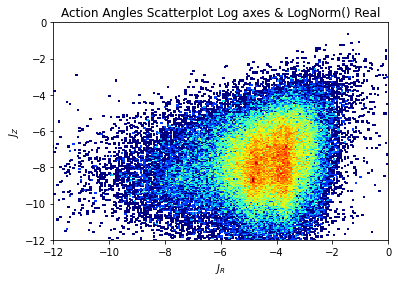

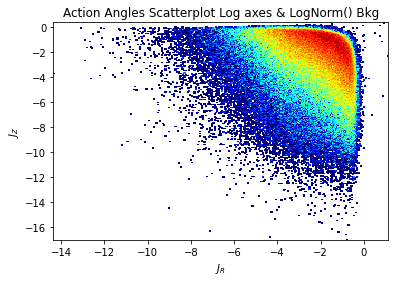

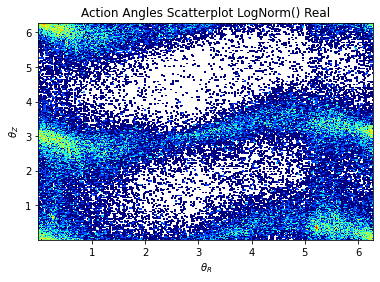

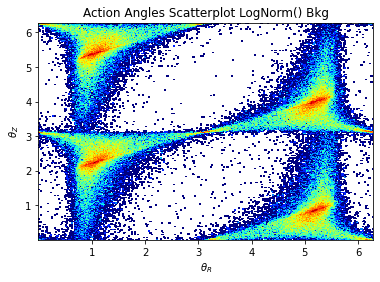

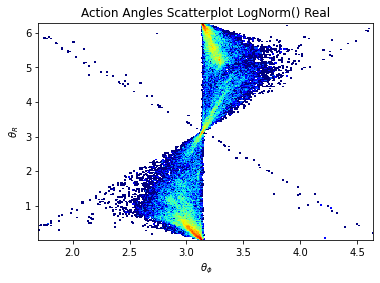

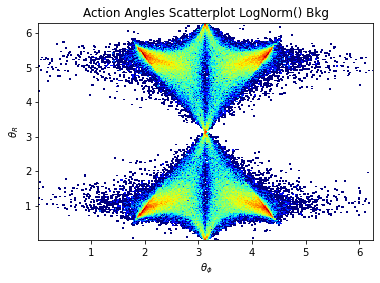

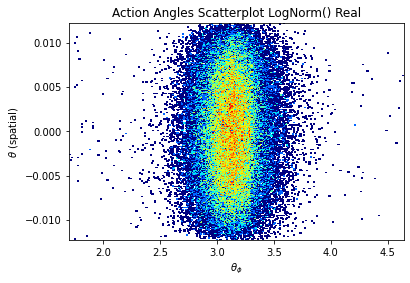

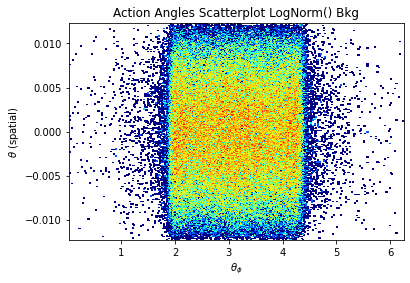

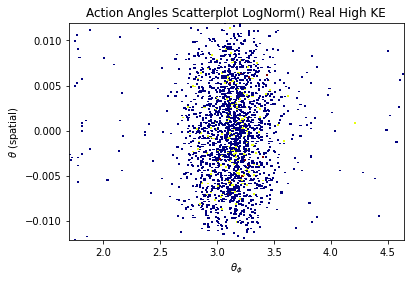

In [24]:
print(jr)
print(lz)
print(jz)

# PLOTTING ACTION ANGLE HISTOGRAMS 
from matplotlib.colors import LogNorm
fig = plt.figure()
plt.hist2d(np.log(jr), np.log(jz), bins=(300, 300), cmap=plt.cm.jet, norm=LogNorm())
plt.xlabel(r'$J_R$')
plt.ylabel(r'$J_Z$')
plt.ylim(-12,0)
plt.xlim(-12,0)
plt.title("Action Angles Scatterplot Log axes & LogNorm() Real" )
#fig.set_rasterized(True)
plt.savefig("jr_vs_jz.pdf", bbox_inches = "tight")
plt.show()

fig = plt.figure()
plt.hist2d(np.log(jr_bkg), np.log(jz_bkg), bins=(300, 300), cmap=plt.cm.jet, norm=LogNorm())
plt.xlabel(r'$J_R$')
plt.ylabel(r'$J_Z$')
#plt.ylim(-12,0)
#plt.xlim(-12,0)
plt.title("Action Angles Scatterplot Log axes & LogNorm() Bkg" )
fig.set_rasterized(True)
plt.savefig("jr_bkg_vs_jz_bkg.pdf", bbox_inches = "tight")
plt.show()

fig = plt.figure()
plt.hist2d(thetar, thetaz, bins=(300, 300), cmap=plt.cm.jet, norm=LogNorm())
plt.xlabel(r'$\theta_R$')
plt.ylabel(r'$\theta_Z$')
#plt.ylim(-10,2)
#plt.xlim(-10,2)
plt.title("Action Angles Scatterplot LogNorm() Real" )
fig.set_rasterized(True)
plt.savefig("thetaR_vs_thetaZ.pdf", bbox_inches = "tight")
plt.show()

fig = plt.figure()
plt.hist2d(thetar_bkg, thetaz_bkg, bins=(300, 300), cmap=plt.cm.jet, norm=LogNorm())
plt.xlabel(r'$\theta_R$')
plt.ylabel(r'$\theta_Z$')
#plt.ylim(-10,2)
#plt.xlim(-10,2)
plt.title("Action Angles Scatterplot LogNorm() Bkg" )
fig.set_rasterized(True)
plt.savefig("thetaR_bkg_vs_thetaZ_bkg.pdf", bbox_inches = "tight")
plt.show()

fig = plt.figure()
plt.hist2d(thetaphi, thetar, bins=(300, 300), cmap=plt.cm.jet, norm=LogNorm())
plt.xlabel(r'$\theta_{\phi}$')
plt.ylabel(r'$\theta_R$')
#plt.ylim(-10,2)
#plt.xlim(-10,2)
plt.title("Action Angles Scatterplot LogNorm() Real" )
fig.set_rasterized(True)
plt.savefig("thetaphi_vs_thetaR.pdf", bbox_inches = "tight")
plt.show()

fig = plt.figure()
plt.hist2d(thetaphi_bkg, thetar_bkg, bins=(300, 300), cmap=plt.cm.jet, norm=LogNorm())
plt.xlabel(r'$\theta_{\phi}$')
plt.ylabel(r'$\theta_R$')
#plt.ylim(-10,2)
#plt.xlim(-10,2)
plt.title("Action Angles Scatterplot LogNorm() Bkg" )
fig.set_rasterized(True)
plt.savefig("thetaphi_bkg_vs_thetaR_bkg.pdf", bbox_inches = "tight")
plt.show()

fig = plt.figure()
plt.hist2d(thetaphi, theta, bins=(300, 300), cmap=plt.cm.jet, norm=LogNorm())
plt.xlabel(r'$\theta_{\phi}$')
plt.ylabel(r'$\theta$ (spatial)')
#plt.ylim(-10,2)
#plt.xlim(-10,2)
plt.title("Action Angles Scatterplot LogNorm() Real" )
fig.set_rasterized(True)
plt.savefig("thetaphi_vs_theta.pdf",bbox_inches = "tight")
plt.show()

fig = plt.figure()
plt.hist2d(thetaphi_bkg, theta_bkg, bins=(300, 300), cmap=plt.cm.jet, norm=LogNorm())
plt.xlabel(r'$\theta_{\phi}$')
plt.ylabel(r'$\theta$ (spatial)')
#plt.ylim(-10,2)
#plt.xlim(-10,2)
plt.title("Action Angles Scatterplot LogNorm() Bkg" )
fig.set_rasterized(True)
plt.savefig("thetaphi_bkg_vs_theta_bkg.pdf", bbox_inches = "tight")
plt.show()

fig = plt.figure()
plt.hist2d(thetaphi_highKE, theta_highKE, bins=(300, 300), cmap=plt.cm.jet, norm=LogNorm())
plt.xlabel(r'$\theta_{\phi}$')
plt.ylabel(r'$\theta$ (spatial)')
#plt.ylim(-10,2)
#plt.xlim(-10,2)
plt.title("Action Angles Scatterplot LogNorm() Real High KE" )
fig.set_rasterized(True)
plt.savefig("thetaphi_vs_theta_highKE.pdf", bbox_inches = "tight")
plt.show()

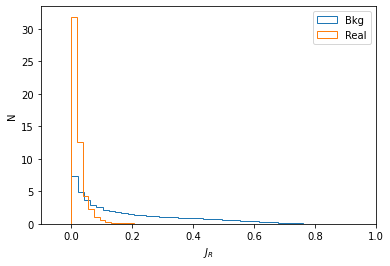

In [29]:
plt.hist(jr_bkg, bins=150, histtype = 'step', density=True, label = 'Bkg')
plt.hist(jr, bins=150, histtype = 'step', density=True, label = 'Real')
plt.xlim(-0.1, 1.0)
plt.xlabel(r'$J_R$')
plt.ylabel('N')
plt.legend()
plt.show()

In [ ]:
len(jr)
print(size)

217899


In [30]:
points_real = []
size = len(jr)
for i in range(size):
  pt = [thetar[i], thetaphi[i], thetaz[i]]
  points_real.append(pt)

points_bkg = []
size = len(thetar_bkg)
for i in range(size):
  pt = [thetar_bkg[i], thetaphi_bkg[i], thetaz_bkg[i]]
  points_bkg.append(pt)


points_highKE = []
size = len(thetaphi_highKE)
for i in range(size):
  pt = [thetar_highKE[i], thetaphi_highKE[i], thetaz_highKE[i]]
  points_highKE.append(pt)

In [ ]:
# v = VoronoiTess(points)
np.savetxt("thetar_highKE", thetar_highKE)
np.savetxt("thetaphi_highKE", thetaphi_highKE)
np.savetxt("thetaz_highKE", thetaz_highKE)
np.savetxt("thetar_bkg", thetar_bkg)
np.savetxt("thetaphi_bkg", thetaphi_bkg)
np.savetxt("thetaz_bkg", thetaz_bkg)
np.savetxt("thetar_real", thetar)
np.savetxt("thetaphi_real", thetaphi)
np.savetxt("thetaz_real", thetaz)


In [29]:
thetar_highKE = np.loadtxt("thetar_highKE")
thetaz_highKE = np.loadtxt("thetaz_highKE")
thetaphi_highKE = np.loadtxt("thetaphi_highKE")
points_highKE = []
size = len(thetaphi_highKE)
for i in range(size):
  pt = [thetar_highKE[i], thetaphi_highKE[i], thetaz_highKE[i]]
  points_highKE.append(pt)

In [31]:
from scipy.spatial import Voronoi, voronoi_plot_2d, ConvexHull
#vor_real = Voronoi(points_real)
#vor_bkg = Voronoi(points_bkg)
#print(vor_real.vertices)
#v_highKE = Voronoi(points_highKE)
#vor_real.regions
#v_bkg = Voronoi(points_bkg)

In [94]:
v_bkg = Voronoi(points_bkg)
v_highKE = Voronoi(points_highKE)
v_real = Voronoi(points_real)

In [ ]:
#v_highKE.regions

In [ ]:
thetaphi_bkg

array([3.40245531, 1.91610505, 2.28436611, ..., 2.94255204, 4.01769577,
       3.99333114])

In [32]:
# Find Cell volumes by constructing convex hulls
def voronoi_volumes(points):
    v = Voronoi(points)
    vol = np.zeros(v.npoints)
    for i, reg_num in enumerate(v.point_region):
        if reg_num == len(points):
          continue
        indices = v.regions[reg_num]
        
        if -1 in indices: # some regions can be opened
            vol[reg_num] = np.inf
        else:
            vol[reg_num] = ConvexHull(v.vertices[indices]).volume
    return vol

In [ ]:
len(points_bkg)

217899

In [34]:
# Collect cell volumes and number of infs for BKG
vor_vol_temp = voronoi_volumes(points_bkg)
vor_vol_bkg = []
thetaphi_bkg_new = []
thetar_bkg_new = []
thetaz_bkg_new = []
s = len(vor_vol_temp)-1
count_inf = 0
for i in range(s):
  if (not math.isinf(vor_vol_temp[i])) and vor_vol_temp[i]!=0.0:
    vor_vol_bkg.append(vor_vol_temp[i])
    thetaphi_bkg_new.append(thetaphi_bkg[i])
    thetar_bkg_new.append(thetar_bkg[i])
    thetaz_bkg_new.append(thetaz_bkg[i])
  if math.isinf(vor_vol_temp[i]):
    count_inf = count_inf+1


In [37]:
# Collect cell volumes and number of infs for highKE
vor_vol_temp = voronoi_volumes(points_highKE)
vor_vol_highKE = []
thetaphi_highKE_new = []
thetar_highKE_new = []
thetaz_highKE_new = []
s = len(vor_vol_temp)-1
count_inf = 0
for i in range(s):
  if (not math.isinf(vor_vol_temp[i])) and vor_vol_temp[i]!=0.0:
    vor_vol_highKE.append(vor_vol_temp[i])
    thetaphi_highKE_new.append(thetaphi_bkg[i])
    thetar_highKE_new.append(thetar_highKE[i])
    thetaz_highKE_new.append(thetaz_highKE[i])
  if math.isinf(vor_vol_temp[i]):
    count_inf = count_inf+1
print(max(vor_vol_highKE))

812168.7391495919


In [38]:
# Collect cell volumes and number of infs for full real data
vor_vol_temp = voronoi_volumes(points_real)
vor_vol_real = []
thetaphi_real_new = []
thetar_real_new = []
thetaz_real_new = []
s = len(vor_vol_temp)-1
count_inf = 0
for i in range(s):
  if (not math.isinf(vor_vol_temp[i])) and vor_vol_temp[i]!=0.0:
    vor_vol_real.append(vor_vol_temp[i])
    thetaphi_real_new.append(thetaphi[i])
    thetar_real_new.append(thetar[i])
    thetaz_real_new.append(thetaz[i])
  if math.isinf(vor_vol_temp[i]):
    count_inf = count_inf+1
print(max(vor_vol_real))

30753321496.474884


In [56]:
len(vor_vol_real)

72541

In [123]:
min(vor_vol_bkg)

0.0

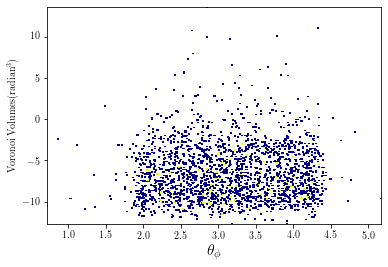

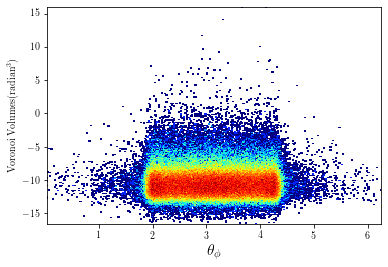

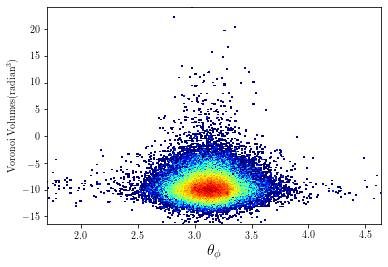

In [162]:
#from matplotlib.colors import LogNorm
#plt.scatter(thetaphi_highKE_new, np.log(vor_vol_highKE), color='r', alpha=1, s=5)
#plt.plot(thetaphi_highKE_new, vor_vol_highKE,'o')
fig = plt.figure()
plt.hist2d(thetaphi_highKE_new, np.log(vor_vol_highKE), bins = (300,300), cmap=plt.cm.jet, norm=LogNorm())

#plt.ylim(0,1)
plt.xlabel(r'$\theta_\phi$', fontsize=16)
plt.ylabel('Voronoi Volumes(radian$^3$)')

#plt.yscale('log')
plt.savefig('vol_vs_thetaphi_highKE.pdf', bbox_inches = 'tight')
plt.show()


fig = plt.figure()
plt.hist2d(thetaphi_bkg_new, np.log(vor_vol_bkg), bins = (300,300), cmap=plt.cm.jet, norm=LogNorm())
#plt.plot(thetar_bkg_new, vor_vol_bkg,'o')
#plt.hist2d(thetaphi_highKE, theta_highKE, bins=(300, 300), cmap=plt.cm.jet, norm=LogNorm())
#plt.ylim(0,1)
plt.xlabel(r'$\theta_\phi$', fontsize=16)
plt.ylabel('Voronoi Volumes(radian$^3$)')

plt.savefig('vol_vs_thetaphi_bkg.pdf', bbox_inches = 'tight')
#plt.yscale('log')
plt.show()


fig = plt.figure()
plt.hist2d(thetaphi_real_new, np.log(vor_vol_real), bins = (300,300), cmap=plt.cm.jet, norm=LogNorm())

#plt.plot(thetar_real_new, vor_vol,'o')
#plt.hist2d(thetaphi_highKE, theta_highKE, bins=(300, 300), cmap=plt.cm.jet, norm=LogNorm())

#plt.ylim(0,1)
plt.xlabel(r'$\theta_\phi$', fontsize=16)
plt.ylabel('Voronoi Volumes(radian$^3$)')
plt.savefig('vol_vs_thetaphi_real.pdf', bbox_inches = 'tight')
#plt.yscale('log')
plt.show()

# Sorting and Cumulative Volume fraction for KS

In [39]:
vor_vol_highKE = np.sort(np.array(vor_vol_highKE))
cuml_array_highKE = np.arange(1,len(vor_vol_highKE)+1, 1)
#cum_vor_vol = np.cumsum(vor_vol)/np.sum(vor_vol)
cuml_array_highKE = cuml_array_highKE/cuml_array_highKE[-1]

In [40]:
vor_vol_bkg = np.sort(np.array(vor_vol_bkg))
cuml_array_bkg = np.arange(1,len(vor_vol_bkg)+1, 1)
#cum_vor_vol = np.cumsum(vor_vol)/np.sum(vor_vol)
cuml_array_bkg = cuml_array_bkg/cuml_array_bkg[-1]

In [41]:
vor_vol_real = np.sort(np.array(vor_vol_real))
cuml_array_real = np.arange(1,len(vor_vol_real)+1, 1)
#cum_vor_vol = np.cumsum(vor_vol)/np.sum(vor_vol)
cuml_array_real = cuml_array_real/cuml_array_real[-1]

In [42]:
cuml_array_bkg

array([4.59170554e-06, 9.18341109e-06, 1.37751166e-05, ...,
       9.99990817e-01, 9.99995408e-01, 1.00000000e+00])

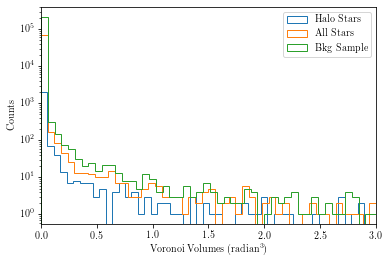

In [160]:
# Plot cell volume distribution
plt.hist(vor_vol_highKE[0:-50], bins = 50, histtype='step', label = 'Halo Stars')
plt.hist(vor_vol_real[0:-185], bins = 50, histtype='step', label = 'All Stars')
plt.hist(vor_vol_bkg[0:-130], bins = 50, histtype='step', label = 'Bkg Sample')
plt.xlim(0,3)
#plt.ylim(0,200)
plt.yscale('log')
#plt.xscale('log')
plt.xlabel(r"Voronoi Volumes (radian$^3$)")
plt.ylabel("Counts")
plt.legend()
plt.savefig("voronoi_volumes.pdf")
plt.show()


In [111]:
np.mean(vor_vol_real[0:-5])

160.14791906393543

In [104]:
np.mean(vor_vol_bkg)

85.59081205128038

In [105]:
np.mean(vor_vol_highKE)

442.69813397409456

In [44]:
print(len(vor_vol_bkg))
print(len(cuml_array_bkg))
print(len(cuml_array_real))

217784
217784
72540


In [45]:
vor_vol_bkg

array([5.89562657e-08, 6.24137980e-08, 6.82683410e-08, ...,
       1.26243603e+06, 8.33368833e+06, 8.84006932e+06])

In [46]:
vor_vol_real

array([7.09503787e-08, 8.86005539e-08, 9.99789305e-08, ...,
       7.78307795e+08, 4.84319728e+09, 3.07533215e+10])

In [156]:
! sudo apt-get install texlive-latex-recommended 
! sudo apt install texlive-latex-extra
! sudo apt install dvipng

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-lmodern fonts-noto-mono libcupsfilters1
  libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0 libkpathsea6
  libpotrace0 libptexenc1 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13
  lmodern poppler-data t1utils tex-common texlive-base texlive-binaries
  texlive-latex-base
Suggested packages:
  fonts-noto poppler-utils ghostscript fonts-japanese-mincho
  | fonts-ipafont-mincho fonts-japanese-gothic | fonts-ipafont-gothic
  fonts-arphic-ukai fonts-arphic-uming fonts-nanum debhelper gv
  | postscript-viewer perl-tk xpdf-reader | pdf-viewer texlive-latex-base-doc
  texlive-latex-recommended-doc texlive-pstricks
The following NEW packages will be installed:
  fonts-d

In [158]:
!apt install cm-super

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  cm-super-minimal pfb2t1c2pfb
The following NEW packages will be installed:
  cm-super cm-super-minimal pfb2t1c2pfb
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 24.5 MB of archives.
After this operation, 59.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 cm-super-minimal all 0.3.4-11 [5,810 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 pfb2t1c2pfb amd64 0.3-11 [9,342 B]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 cm-super all 0.3.4-11 [18.7 MB]
Fetched 24.5 MB in 1s (17.4 MB/s)
Selecting previously unselected package cm-super-minimal.
(Reading database ... 186568 files and directories

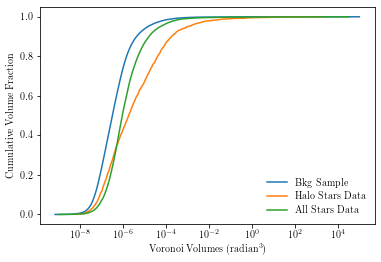

72540

In [174]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.plot(vor_vol_bkg/np.mean(vor_vol_bkg), cuml_array_bkg, '-', label = 'Bkg Sample')
plt.plot(vor_vol_highKE/np.mean(vor_vol_highKE), cuml_array_highKE, '-', label = 'Halo Stars Data')
plt.plot(vor_vol_real[0:-6]/np.mean(vor_vol_real[0:-6]), cuml_array_real[0:-6], '-', label = 'All Stars Data')

#plt.xlim(0,0.0001)
#plt.title("Kolmogorov-Smirnov Statistic Test")
plt.xlabel("Voronoi Volumes (radian$^3$)")
plt.ylabel("Cumulative Volume Fraction")
plt.xscale('log')
plt.legend(frameon=False)
##plt.ylim(-0.0001,0.2)
plt.savefig("ks_test.pdf")
plt.show()

len(vor_vol_real)

In [151]:
from scipy import stats
print(stats.ks_2samp(vor_vol_bkg, vor_vol_highKE))
print(stats.ks_2samp(vor_vol_real, vor_vol_highKE))
print(stats.ks_2samp(vor_vol_bkg, vor_vol_real))

Ks_2sampResult(statistic=0.5428049104089424, pvalue=0.0)
Ks_2sampResult(statistic=0.3998317984245674, pvalue=1.7018898208421282e-301)
Ks_2sampResult(statistic=0.22029478552094034, pvalue=0.0)


In [ ]:
stats.ks_2samp(cuml_array_bkg, cuml_array_highKE)